
# Educación, PIB y Edad de Maternidad

## Metodología de los datos

Este notebook utiliza datos abiertos recopilados por *Our World in Data (OWID)*, que actúa como repositorio y espejo de fuentes oficiales.  
Las variables provienen de las siguientes instituciones:

- **Edad media de la maternidad (Mean age of childbearing, MAC):**  
  Fuente original: *United Nations, Department of Economic and Social Affairs (UN DESA), Population Division* – *World Population Prospects*.  
  OWID publica la serie armonizada para análisis comparativos entre países.

- **PIB per cápita:**  
  Fuente original: *World Bank – World Development Indicators (WDI)*.  
  OWID ofrece la serie ajustada en dólares internacionales.

- **Años de escolaridad promedio (Average years of schooling):**  
  Fuente original: *United Nations Development Programme (UNDP), Human Development Reports*.  
  OWID mantiene la base de datos accesible en formato abierto.

> **Nota:** OWID no produce los datos, sino que los consolida y documenta para facilitar su acceso y análisis.



#### Instalación de librerías


In [1]:

%pip install -q pandas plotly requests

import warnings
warnings.filterwarnings('ignore')

import requests
import io
import pandas as pd

Note: you may need to restart the kernel to use updated packages.



## Carga de datos desde Our World in Data
Descargamos CSVs desde el *Grapher* de OWID.


In [2]:
def load_csv(url):
    headers = {"User-Agent": "Mozilla/5.0"}  
    r = requests.get(url, headers=headers)
    r.raise_for_status()  
    return pd.read_csv(io.StringIO(r.text))
    
URL_MAC = "https://ourworldindata.org/grapher/period-average-age-of-mothers.csv?v=1&csvType=full&useColumnShortNames=true"
URL_GDP = "https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv?useColumnShortNames=true&csvType=full"
URL_EDU = "https://ourworldindata.org/grapher/average-years-of-schooling.csv?useColumnShortNames=true&csvType=full"

mac = load_csv(URL_MAC)
gdp = load_csv(URL_GDP)
edu = load_csv(URL_EDU)


print(mac.head())
print(gdp.head())
print(edu.head())

        Entity Code  Year  mean_age_childbearing_hist
0  Afghanistan  AFG  1950                      29.226
1  Afghanistan  AFG  1951                      29.239
2  Afghanistan  AFG  1952                      29.251
3  Afghanistan  AFG  1953                      29.264
4  Afghanistan  AFG  1954                      29.277
        Entity Code  Year  ny_gdp_pcap_pp_kd owid_region
0  Afghanistan  AFG  2000          1617.8264         NaN
1  Afghanistan  AFG  2001          1454.1108         NaN
2  Afghanistan  AFG  2002          1774.3087         NaN
3  Afghanistan  AFG  2003          1815.9282         NaN
4  Afghanistan  AFG  2004          1776.9182         NaN
        Entity Code  Year  mys__sex_total owid_region
0  Afghanistan  AFG  1990        0.871962         NaN
1  Afghanistan  AFG  1991        0.915267         NaN
2  Afghanistan  AFG  1992        0.958573         NaN
3  Afghanistan  AFG  1993        1.001878         NaN
4  Afghanistan  AFG  1994        1.045184         NaN


In [3]:
# Renombrar columnas
mac = mac.rename(columns={"Entity":"country", "Year":"year", "Code":"code",
                          "mean_age_childbearing_hist":"mac"})

gdp = gdp.rename(columns={"Entity":"country", "Year":"year", "Code":"code",
                          "ny_gdp_pcap_pp_kd":"gdp_per_capita"})

edu = edu.rename(columns={"Entity":"country", "Year":"year", "Code":"code",
                          "mys__sex_total":"edu_years"})


In [4]:
# Unificar
df = mac.merge(gdp, on=["country","year","code"], how="inner") \
        .merge(edu, on=["country","year","code"], how="inner")

# Limpiar filas nulas en columnas clave
df = df.dropna(subset=["mac","gdp_per_capita","edu_years"]).reset_index(drop=True)

# Eliminar columnas innecesarias
df = df.drop(columns=["owid_region_x", "owid_region_y"])
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         6001 non-null   object 
 1   code            5899 non-null   object 
 2   year            6001 non-null   int64  
 3   mac             6001 non-null   float64
 4   gdp_per_capita  6001 non-null   float64
 5   edu_years       6001 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 281.4+ KB
None


,country,code,year,mac,gdp_per_capita,edu_years
0,Afghanistan,AFG,2000,29.445,1617.8264,1.264052
1,Afghanistan,AFG,2001,29.363,1454.1108,1.315551
2,Afghanistan,AFG,2002,29.268,1774.3087,1.367049
3,Afghanistan,AFG,2003,29.295,1815.9282,1.418548
4,Afghanistan,AFG,2004,29.279,1776.9182,1.470046


In [5]:
# Filtro: mantener solo países (excluir regiones agregadas si es necesario)
# Muchas series OWID usan 'Code' ISO3 para países. Eliminamos filas sin Code.

df = df[df["code"].notna()].copy()


In [6]:
# Limpieza de valores
for col in ["mac","gdp_per_capita","edu_years"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["mac","gdp_per_capita","edu_years"]).reset_index(drop=True)


In [7]:
# Año más reciente común por país
latest = df.sort_values("year").groupby("country").tail(1).copy()
latest_year = int(latest["year"].median())  # referencia
latest_year


2023


### Vistazo a los datos combinados


In [8]:

df.head(10)  # primeras filas combinadas


,country,code,year,mac,gdp_per_capita,edu_years
0,Afghanistan,AFG,2000,29.445,1617.8264,1.264052
1,Afghanistan,AFG,2001,29.363,1454.1108,1.315551
2,Afghanistan,AFG,2002,29.268,1774.3087,1.367049
3,Afghanistan,AFG,2003,29.295,1815.9282,1.418548
4,Afghanistan,AFG,2004,29.279,1776.9182,1.470046
5,Afghanistan,AFG,2005,29.257,1908.1147,1.521544
6,Afghanistan,AFG,2006,29.219,1929.7239,1.595281
7,Afghanistan,AFG,2007,29.202,2155.3530,1.669017
8,Afghanistan,AFG,2008,29.114,2191.5044,1.742754
9,Afghanistan,AFG,2009,29.203,2565.0220,1.816490



## Edad media de maternidad vs PIB per cápita
Color = Años de escolaridad. Tamaño opcional = PIB per cápita.


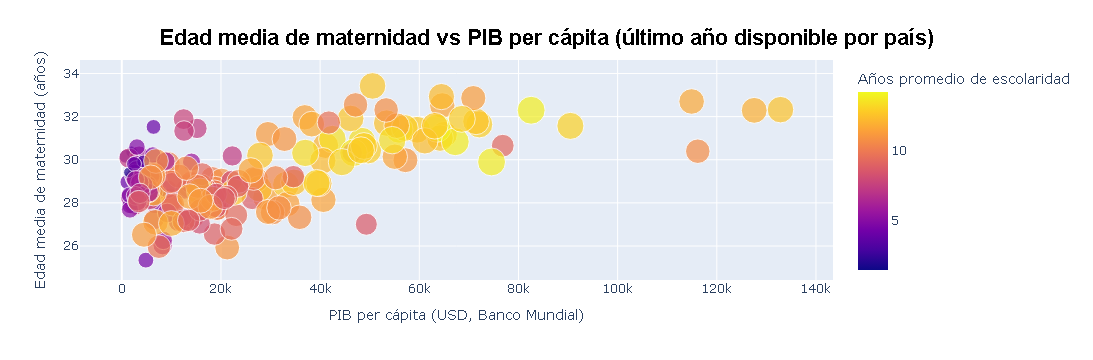

In [13]:
import pandas as pd
import plotly.express as px

# 1) Asegurar nombres de columnas y tipos
df = df.rename(columns={"Entity":"country", "Year":"year"})  # si ya están así, no pasa nada
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# 2) Filtrar filas con datos válidos en las 3 métricas
need_cols = ["country", "year", "gdp_per_capita", "mac", "edu_years"]
df_valid = df.dropna(subset=need_cols).copy()

# 3) Quedarse con el último año disponible por país
df_latest = df_valid.loc[df_valid.groupby("country")["year"].idxmax()].reset_index(drop=True)

# 4) Scatter
fig_scatter = px.scatter(
    df_latest,
    x="gdp_per_capita",
    y="mac",
    size="edu_years",
    color="edu_years",
    hover_name="country",
    hover_data={
        "year": True,
        "mac": ":.1f",
        "gdp_per_capita": ":,.0f",
        "edu_years": ":.1f"
    },
    labels={
        "year": "Año",
        "mac": "Edad media de maternidad",
        "gdp_per_capita": "PIB per cápita (USD)",
        "edu_years": "Años promedio de escolaridad"
    }
)

fig_scatter.update_layout(
    title={
        "text": "<b>Edad media de maternidad vs PIB per cápita (último año disponible por país)</b>",
        "x": 0.5, "xanchor": "center", "yanchor": "top"
    },
    title_font=dict(size=22, family="Arial", color="black"),
    xaxis_title="PIB per cápita (USD, Banco Mundial)",
    yaxis_title="Edad media de maternidad (años)"
)

fig_scatter.show()


### Mayor educación, maternidad más tardía:
Se observa que los países con más años promedio de escolaridad concentran también edades más altas de maternidad. Esto sugiere que una mayor permanencia en el sistema educativo retrasa la edad en que las mujeres tienen hijos.

### Relación positiva entre educación y riqueza:
El color (años de escolaridad) muestra una clara gradiente: los países con mayor PIB per cápita tienden a registrar también más años de educación formal.

### Desigualdades regionales marcadas:
Mientras que países de altos ingresos superan los 12 años promedio de escolaridad, en naciones de ingresos bajos apenas se alcanzan entre 4 y 6 años, reflejando brechas educativas que impactan en el desarrollo humano.



## Evolución: Edad media de maternidad vs PIB per cápita


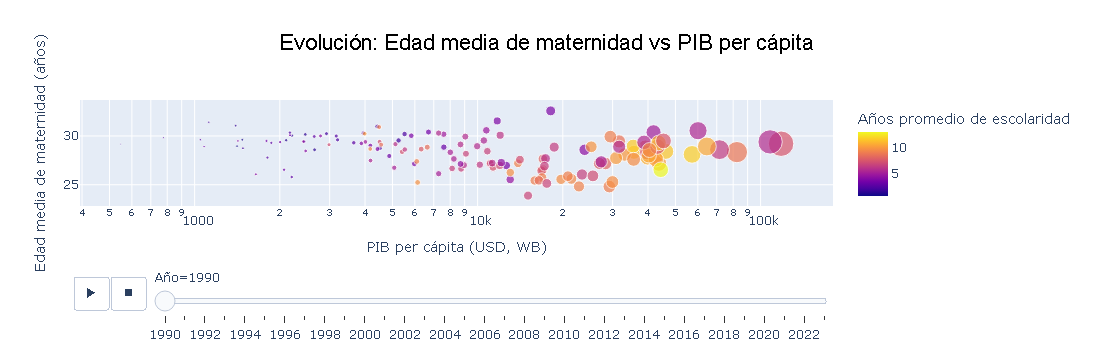

In [14]:
import numpy as np
import plotly.express as px
import pandas as pd

# Asegurar tipos numéricos
for c in ["gdp_per_capita", "mac", "edu_years"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Año como entero
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Quitar infinitos y NaN
df = df.replace([np.inf, -np.inf], np.nan)
df_pos = df.dropna(subset=["year", "gdp_per_capita", "mac", "edu_years"])

# Filtrar para log (>0)
df_pos = df_pos[(df_pos["gdp_per_capita"] > 0) & (df_pos["mac"] > 0)]

years_order = sorted(df_pos["year"].unique())

fig_bubble = px.scatter(
    df_pos,
    x="gdp_per_capita",
    y="mac",
    color="edu_years",
    hover_name="country",
    size="gdp_per_capita",
    animation_frame="year",
    animation_group="country",
    category_orders={"year": years_order},
    labels={
        "gdp_per_capita": "PIB per cápita (USD, WB)",
        "mac": "Edad media de maternidad (años)",
        "edu_years": "Años promedio de escolaridad",
        "year": "Año",
    },
    title="Evolución: Edad media de maternidad vs PIB per cápita"
)

fig_bubble.update_layout(coloraxis_colorbar=dict(title="Años promedio de escolaridad"))
fig_bubble.update_xaxes(type="log")  # sin range_x
fig_bubble.update_layout(
    title_x=0.5,                  
    title_font=dict(size=22, family="Arial", color="black"),      
)
fig_bubble.show()



## Mapa: Edad media de maternidad 


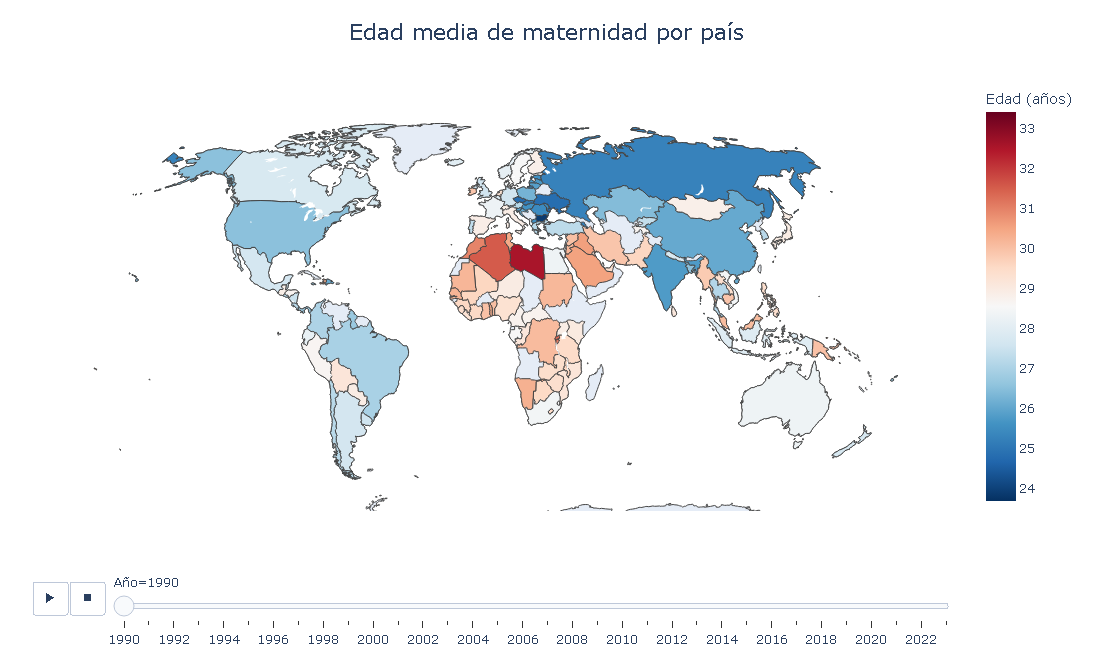

In [15]:
import pandas as pd
import plotly.express as px
import numpy as np

# --- Asegurar tipos ---
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["mac"] = pd.to_numeric(df["mac"], errors="coerce")
df["edu_years"] = pd.to_numeric(df["edu_years"], errors="coerce")
df["gdp_per_capita"] = pd.to_numeric(df["gdp_per_capita"], errors="coerce")

# --- Ordenar años ---
years_order = sorted(df["year"].dropna().unique())
df = df[df["year"].isin(years_order)].copy()

# --- Rango de color estable para comparaciones ---
vmin = df["mac"].min()
vmax = df["mac"].max()

# --- Mapa coroplético animado ---
fig_map = px.choropleth(
    df,
    locations="code",                   
    color="mac",                        
    hover_name="country",               
    hover_data={                        
        "edu_years": ':.2f',
        "gdp_per_capita": ':.0f',
        "year": True
    },
    animation_frame="year",             
    category_orders={"year": years_order},  
    color_continuous_scale="RdBu_r",
    range_color=(vmin, vmax),
    labels={
        "mac": "Edad media de maternidad (años)",
        "edu_years": "Años promedio de escolaridad",
        "gdp_per_capita": "PIB per cápita (USD, WB)",
        "year": "Año"
    },
    title="Edad media de maternidad por país"
)

fig_map.update_layout(
    title_x=0.5,
    title_font=dict(size=22),
    coloraxis_colorbar=dict(title="Edad (años)"),
    height=650,   # más alto
    width=1100,   # más ancho
    margin=dict(l=20, r=20, t=80, b=40),
    geo=dict(
        projection_type="natural earth",  
        showframe=False,
        showcoastlines=True,
        fitbounds="locations"             
    )
)

fig_map.show()



---

### Notas metodológicas y advertencias
- **Edad media de maternidad (MAC)** es un indicador estándar construido a partir de tasas específicas de fecundidad por edad. Aunque no es exactamente la **edad al primer embarazo**, está **altamente correlacionada** con el calendario reproductivo y funciona muy bien para análisis comparativos entre países.
- Algunas series pueden no coincidir en todos los años para todos los países; el gráfico de puntos usa el **último año disponible** por país.
- **PIB per cápita** proviene del Banco Mundial (espejado en OWID) y puede estar en **USD constantes** 

### Exportar
Se puede exportar cualquier figura con `fig.write_html("grafico.html")` o `fig.write_image("grafico.png")` (requiere `kaleido`).

